In [128]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [129]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

## 1. Load Datasets

In [134]:
import pathlib
dataset_path = "/content/drive/MyDrive/testData/5dec/datasets"

data_dir = pathlib.Path(dataset_path)
!ls {data_dir}

angry  crying  happy


In [135]:
#all images count in the dataset
image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)

1800


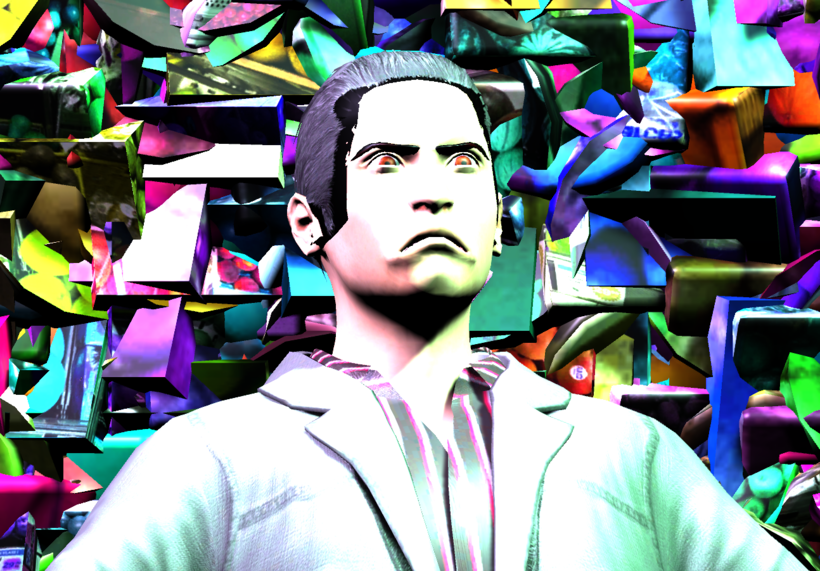

In [136]:
#show first picture in the angry folder
angry_faces = list(data_dir.glob('angry/*'))
PIL.Image.open(str(angry_faces[1]))

##Data Preprocessing

In [137]:
#define variable for later usage
batch_size = 32
img_height = 160
img_width = 160
image_size = (img_width, img_height)
print(image_size)

(160, 160)


train dataset

In [210]:
#Spilt train data set from the whole data set
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  shuffle=True,
  image_size=image_size,
  batch_size=batch_size)

Found 1800 files belonging to 3 classes.
Using 1440 files for training.


Validation dataset

In [211]:
#Spilt validation data set from the whole data set
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  shuffle=True,
  image_size=image_size,
  batch_size=batch_size)

Found 1800 files belonging to 3 classes.
Using 360 files for validation.


In [281]:
#no func
class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names, num_classes)


AttributeError: ignored

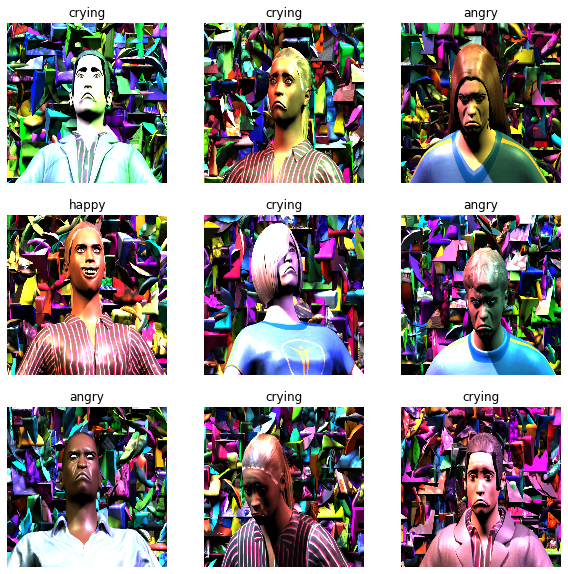

In [213]:
#display some data examples
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [297]:
#show validation data set content
for image_batch, labels_batch in val_ds:
  print('#images, pixels-width, pixels-height, RGB color: ', image_batch.shape)
  print('label vector:', labels_batch)
  print('labels shape:', labels_batch.shape)
  break

#images, pixels-width, pixels-height, RGB color:  (32, 160, 160, 3)
label vector: tf.Tensor([2 1 1 1 0 1 0 0 2 1 0 0 0 0 1 0 1 2 0 1 2 0 1 1 2 1 1 1 2 2 0 1], shape=(32,), dtype=int32)
labels shape: (32,)


In [283]:
#show train data set content
for image_batch, labels_batch in train_ds:
  print('#images, pixels-width, pixels-height, RGB color: ', image_batch.shape)
  print('label vector:', labels_batch)
  print('labels shape:', labels_batch.shape)
  break

#images, pixels-width, pixels-height, RGB color:  (32, 160, 160, 3)
label vector: tf.Tensor([2 2 1 2 1 2 2 0 2 0 0 1 1 0 2 1 0 1 2 0 1 2 1 0 1 0 1 1 1 0 1 1], shape=(32,), dtype=int32)
labels shape: (32,)


### Create Test Data set


In [214]:
#don't click here twice
#spilt 20% of validation data to test set
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 5)
val_ds = val_ds.skip(val_batches // 5)

In [215]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_ds))


Number of validation batches: 10
Number of test batches: 2


### Configure the dataset for performance


In [216]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

### Rescale Images


In [217]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [218]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

## 3. Create the base model from the pre-trained convnets

In [219]:
# Create the base model from the pre-trained model MobileNet V2
# 3 for RGB color so plue three here
image_shape = image_size + (3,)
print('input size', image_shape, image_size, )
#include_top mean does not know the classisfication layer
base_model = tf.keras.applications.MobileNetV2(input_shape=image_shape,
                                               include_top=False,
                                               weights='imagenet')

input size (160, 160, 3) (160, 160)


In [220]:
#No Func, Check example batch only
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


## 4. Feature extraction

### Freeze the convolutional base

In [221]:
#set all nodes in the model are not trainable
base_model.trainable = False

### Important note about BatchNormalization layers***
Many models contain tf.keras.layers.BatchNormalization layers. This layer is a special case and precautions should be taken in the context of fine-tuning, as shown later in this tutorial.

When you set layer.trainable = False, the BatchNormalization layer will run in inference mode, and will not update its mean and variance statistics.

When you unfreeze a model that contains BatchNormalization layers in order to do fine-tuning, you should keep the BatchNormalization layers in inference mode by passing training = False when calling the base model. Otherwise, the updates applied to the non-trainable weights will destroy what the model has learned.

For details, see the Transfer learning guide.

In [222]:
# Take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_14[0][0]                   
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [261]:
#first connection layer after the model
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [260]:
#prediction (output) layer
prediction_layer = tf.keras.layers.Dense(num_classes)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 3)


In [259]:
#define model
inputs = tf.keras.Input(shape=(160, 160, 3))
x = preprocess_input(inputs)
print(x.shape)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
print(outputs.shape)
model = tf.keras.Model(inputs, outputs)
model.summary()

(None, 160, 160, 3)
(None, 3)
Model: "functional_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf_op_layer_RealDiv_14 (Tens [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub_14 (TensorFl [(None, 160, 160, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 1280)              0         
_________________________________________________________________
dense_11 (Dense)       

In [287]:
#update binary cross entropy(0 or 1 only)to SparseCategoricalCrossentropy (1 or more classes)
#model.compile() config the model with losses and metrics
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(
              from_logits=True),
              metrics=['accuracy'])

In [295]:
model.summary()

Model: "functional_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf_op_layer_RealDiv_14 (Tens [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub_14 (TensorFl [(None, 160, 160, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 1280)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 3)               

In [288]:
len(model.trainable_variables)

58

In [296]:
#check init validation
initial_epochs = 10

loss0, accuracy0 = model.evaluate(val_ds)

10/10 [==============================] - 5s 470ms/step - loss: 0.1811 - accuracy: 0.9459


In [266]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 1.65
initial accuracy: 0.30


In [290]:
#train with the datasets
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/10
45/45 [==============================] - 81s 2s/step - loss: 1.1286 - accuracy: 0.3924 - val_loss: 1.0234 - val_accuracy: 0.4358
Epoch 2/10
45/45 [==============================] - 81s 2s/step - loss: 0.7509 - accuracy: 0.6236 - val_loss: 0.5969 - val_accuracy: 0.6554
Epoch 3/10
45/45 [==============================] - 81s 2s/step - loss: 0.3774 - accuracy: 0.8188 - val_loss: 0.2451 - val_accuracy: 0.8953
Epoch 4/10
45/45 [==============================] - 80s 2s/step - loss: 0.1881 - accuracy: 0.9139 - val_loss: 0.3103 - val_accuracy: 0.8851
Epoch 5/10
45/45 [==============================] - 81s 2s/step - loss: 0.1039 - accuracy: 0.9576 - val_loss: 0.1611 - val_accuracy: 0.9291
Epoch 6/10
45/45 [==============================] - 82s 2s/step - loss: 0.0390 - accuracy: 0.9875 - val_loss: 0.1273 - val_accuracy: 0.9595
Epoch 7/10
45/45 [==============================] - 81s 2s/step - loss: 0.0770 - accuracy: 0.9681 - val_loss: 0.2575 - val_accuracy: 0.8953
Epoch 8/10
45/45 [==

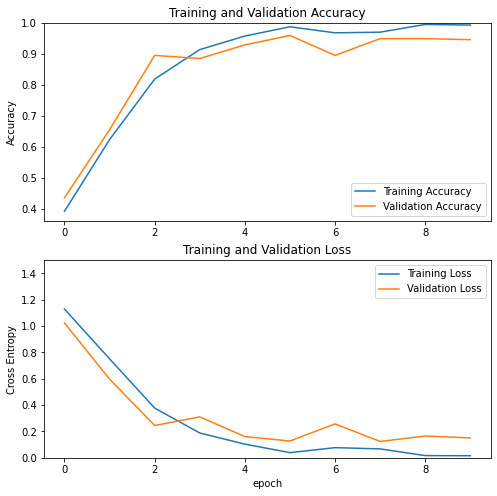

In [291]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.5])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Fine tuning


### Un-freeze the top layers of the model


In [292]:
base_model.trainable = True

In [293]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  155


### Compile the model


In [286]:
#config the model again with new training parameter
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(
              from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [275]:
model.summary()

Model: "functional_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf_op_layer_RealDiv_14 (Tens [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub_14 (TensorFl [(None, 160, 160, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 1280)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 3)               

In [273]:
len(model.trainable_variables)

58

### Continue training the model

In [294]:
print(val_ds)
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs
history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds)
print(history.epoch[-1])

<PrefetchDataset shapes: ((None, 160, 160, 3), (None,)), types: (tf.float32, tf.int32)>
Epoch 10/20
45/45 [==============================] - 81s 2s/step - loss: 0.0278 - accuracy: 0.9868 - val_loss: 0.1299 - val_accuracy: 0.9561
Epoch 11/20
45/45 [==============================] - 81s 2s/step - loss: 0.0306 - accuracy: 0.9868 - val_loss: 0.3124 - val_accuracy: 0.9054
Epoch 12/20
45/45 [==============================] - 82s 2s/step - loss: 0.0316 - accuracy: 0.9910 - val_loss: 0.1649 - val_accuracy: 0.9392
Epoch 13/20
45/45 [==============================] - 83s 2s/step - loss: 0.0150 - accuracy: 0.9937 - val_loss: 0.3215 - val_accuracy: 0.9223
Epoch 14/20
45/45 [==============================] - 80s 2s/step - loss: 0.0330 - accuracy: 0.9882 - val_loss: 0.1294 - val_accuracy: 0.9628
Epoch 15/20
45/45 [==============================] - 81s 2s/step - loss: 0.0075 - accuracy: 0.9965 - val_loss: 0.1704 - val_accuracy: 0.9561
Epoch 16/20
45/45 [==============================] - 80s 2s/step -

In [300]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

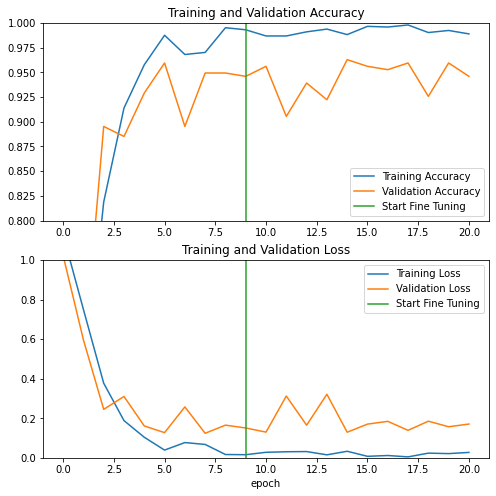

In [301]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [311]:
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)

2/2 [==============================] - 1s 562ms/step - loss: 0.2709 - accuracy: 0.9062
Test accuracy : 0.90625


Predictions:
 [ 6.3002625  -5.2656574  -4.289203    5.5723886  -4.994053   -2.8665245
 -3.9265275   6.3720875  -6.5059824  -5.3698173  -6.015537    8.9852495
  0.5464246  -1.0741749  -1.6538029  -3.7817032  -7.059677    8.199212
 -4.6680365  -6.8645406   9.958549   -6.6691628  -7.534759   11.92675
 -5.7101336  -5.1218243   8.990048    7.183527   -6.2585454  -4.960369
  7.4788704  -5.9332085  -4.9877133  -8.539731   10.2032     -8.085807
 -4.983381    5.887365   -5.6868315  -2.2082615   2.7579877  -4.0827312
  1.6469476  -6.5234566   2.4372523  -7.4644794   8.63672    -7.2183013
 -4.3486776  -7.3707247  10.335419    4.414997   -6.361286   -1.968447
  3.9560475  -1.9898716  -5.108273    4.7145467  -4.0147257  -2.6916282
  3.4441664  -2.6639009  -2.889645    0.7728118   0.05493229 -2.3302698
 -4.476327    4.3825455  -4.605457   -4.0127573  -7.49236     9.500293
 -7.0404444   7.7906003  -5.4813685  -4.66527    -6.67163     9.419332
 -7.0908804  -4.5476303   9.036637    6.1845503  -6.529973

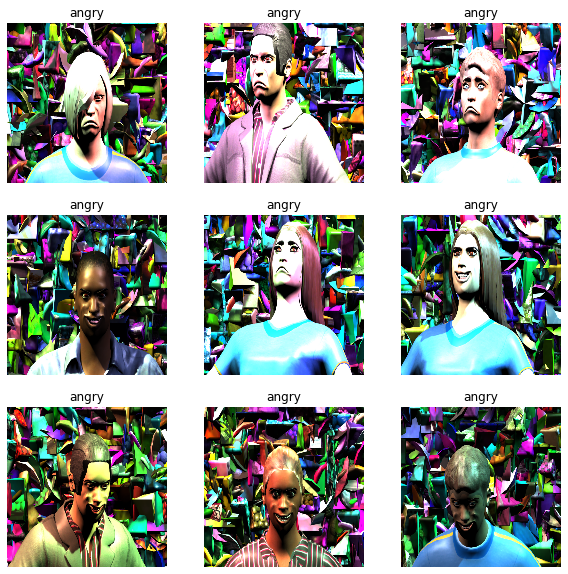

In [310]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()
print('Predictions:\n', predictions)

# Apply a sigmoid since our model returns logits (change to other activaton function)
predictions = tf.nn.softmax(predictions)
print('Predictions:\n', predictions.numpy())

predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")